In [52]:
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import os
import cv2
import json
import glob
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from PIL import Image
import numpy as np
import json
from tqdm import tqdm
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
else:
    device = torch.device("cpu")
    print("Using CPU.")

Using GPU: NVIDIA TITAN X (Pascal)
Number of GPUs available: 1


In [22]:
ROOT_DIR = '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/trichome_dataset'

labels = {}

for folder in os.listdir(ROOT_DIR):
    for file in os.listdir(os.path.join(ROOT_DIR, folder)):
        if file.endswith(".png"):
            full_name = os.path.join(ROOT_DIR, folder, file)
            labels[full_name] = folder

files = labels.keys()

In [4]:
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
dinov2_vits14.to(device)

Using cache found in /home/etaylor/.cache/torch/hub/facebookresearch_dinov2_main
/home/etaylor/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/etaylor/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/etaylor/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [70]:
transform_image = T.Compose([T.ToTensor(), T.Resize(42), T.CenterCrop(42)])

In [71]:
def load_image(img: str) -> torch.Tensor:
    """
    Load an image and return a tensor that can be used as an input to DINOv2.
    """
    img = Image.open(img)

    transformed_img = transform_image(img)[:3].unsqueeze(0)

    return transformed_img

def compute_embeddings(files: list) -> dict:
    """
    Create an index that contains all of the images in the specified list of files.
    """
    all_embeddings = {}
    
    with torch.no_grad():
        for i, file in enumerate(tqdm(files)):
            embeddings = dinov2_vits14(load_image(file).to(device))

            all_embeddings[file] = np.array(embeddings[0].cpu().numpy()).reshape(1, -1).tolist()

    with open("all_embeddings.json", "w") as f:
        f.write(json.dumps(all_embeddings))

    return all_embeddings

In [72]:
embeddings = compute_embeddings(files)

100%|██████████| 2191/2191 [00:18<00:00, 116.76it/s]


In [73]:
y = [labels[file] for file in files]

print(len(embeddings.values()))

embedding_list = list(embeddings.values())

2191


In [74]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm


In [75]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(np.array(embedding_list).reshape(-1, 384), y, test_size=0.2, random_state=42)


Classification Report for SVM:


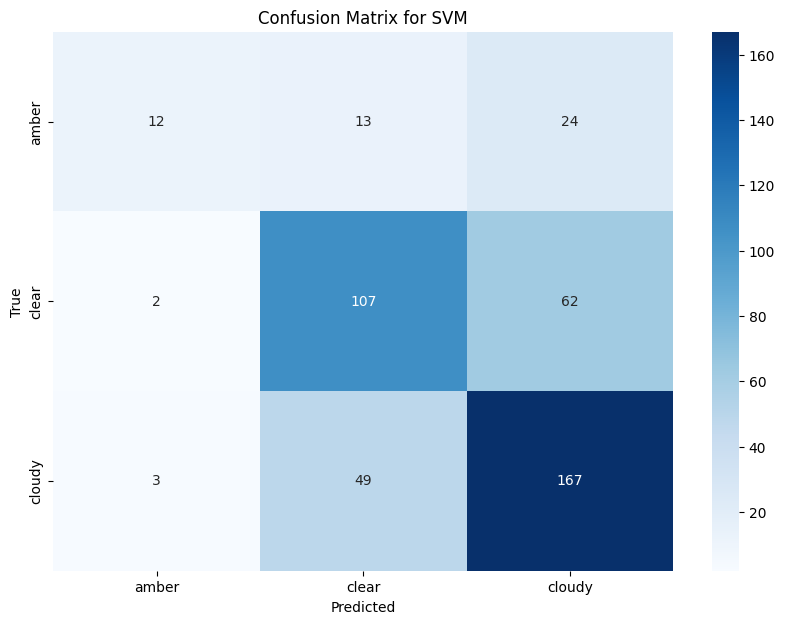

Classification Report for Random Forest:


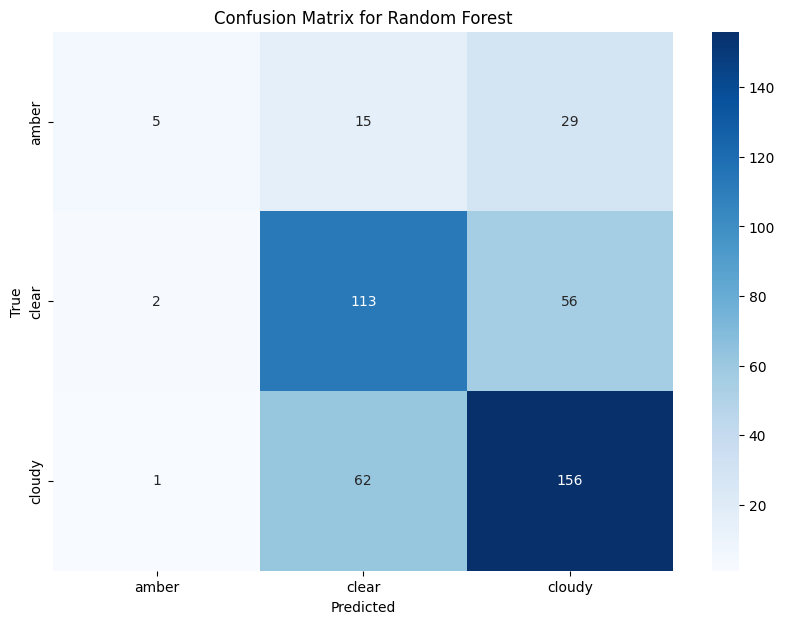

Classification Report for K-Nearest Neighbors:


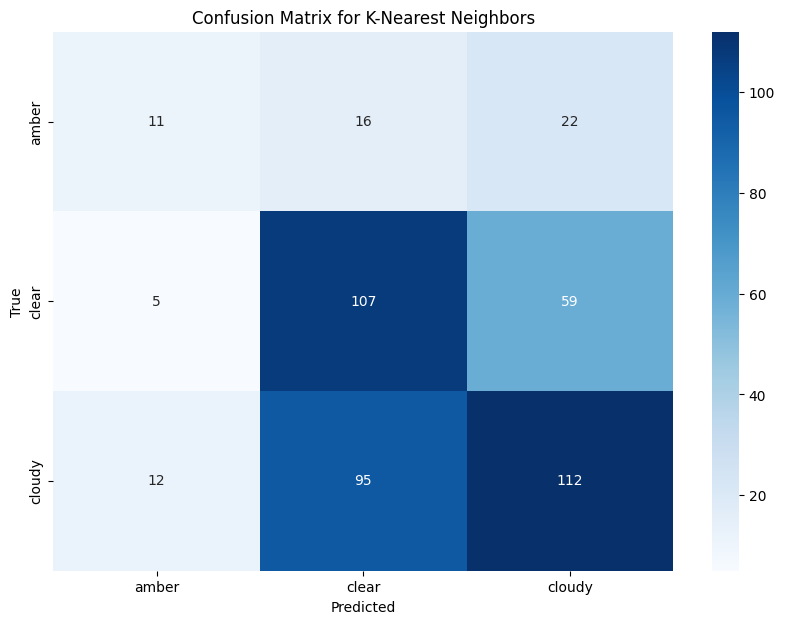

Classification Report for Gradient Boosting:


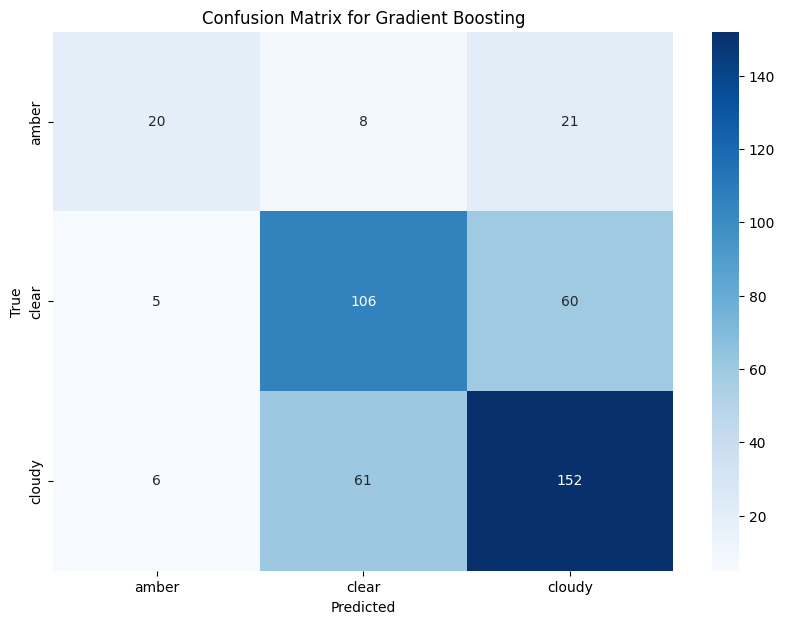

Classification Report for Neural Network:


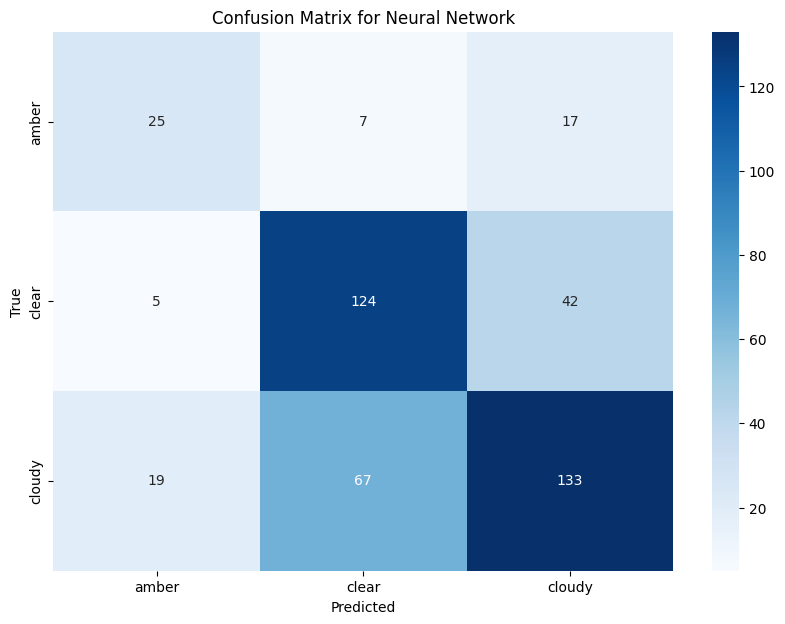


SVM Results:
accuracy: 0.6515
precision_macro: 0.6664
recall_macro: 0.5444
f1_macro: 0.5669
precision_micro: 0.6515
recall_micro: 0.6515
f1_micro: 0.6515

Random Forest Results:
accuracy: 0.6241
precision_macro: 0.6223
recall_macro: 0.4917
f1_macro: 0.4932
precision_micro: 0.6241
recall_micro: 0.6241
f1_micro: 0.6241

K-Nearest Neighbors Results:
accuracy: 0.5239
precision_macro: 0.4880
recall_macro: 0.4539
f1_macro: 0.4598
precision_micro: 0.5239
recall_micro: 0.5239
f1_micro: 0.5239

Gradient Boosting Results:
accuracy: 0.6333
precision_macro: 0.6344
recall_macro: 0.5740
f1_macro: 0.5951
precision_micro: 0.6333
recall_micro: 0.6333
f1_micro: 0.6333

Neural Network Results:
accuracy: 0.6424
precision_macro: 0.6097
recall_macro: 0.6142
f1_macro: 0.6098
precision_micro: 0.6424
recall_micro: 0.6424
f1_micro: 0.6424


In [76]:
classifiers = {
    "SVM": svm.SVC(gamma='scale'),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
}

results = {}

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision_macro = precision_score(y_test, y_pred, average='macro')
    recall_macro = recall_score(y_test, y_pred, average='macro')
    f1_macro = f1_score(y_test, y_pred, average='macro')

    precision_micro = precision_score(y_test, y_pred, average='micro')
    recall_micro = recall_score(y_test, y_pred, average='micro')
    f1_micro = f1_score(y_test, y_pred, average='micro')

    results[name] = {
        "accuracy": accuracy,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro,
        "precision_micro": precision_micro,
        "recall_micro": recall_micro,
        "f1_micro": f1_micro
    }

    # Print classification report
    print(f"Classification Report for {name}:")

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

# Print all results
for name, metrics in results.items():
    print(f"\n{name} Results:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")